# Procedure for statistical analysis of trajectories

1. use the package `MTS` from R to compute the p-values across the `x` and `y` aggregated trajectories. Use a p-value of 1 for trajectories for which there are no observed correlations. This is using the Ljung-Box statistic.
2. Aggregate the p-values using Fisher's method:
`pchisq(-2*sum(log(p-balues)), df, lower.tail=FALSE)` where `df=2*length(p-values)`

In [1]:
library('ggplot2')
library('dplyr')
library('tidyr')
library('MTS')
library('cowplot')
library('psych')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha



In [2]:
trajectories <- read.csv("../data/trajectory_df.csv", header = TRUE)

In [3]:

trajectories$pair_id <- as.factor(trajectories$pair_id)
trajectories$channel <- as.factor(trajectories$channel)

In [4]:
positives = c(    
  #  "with glucose 4 but have flow",
    "with glucose with 20X objective",
    "with glucose 5",
    "with glucose 2",
    "with glucose 3"
     )

negatives = c(
 #   "with glucose 4 but have flow",
    "no glucose",
    "l-glu")

In [5]:
trajectories <- trajectories %>% 
        mutate(positive = ifelse(filename %in% positives, 1, 0))

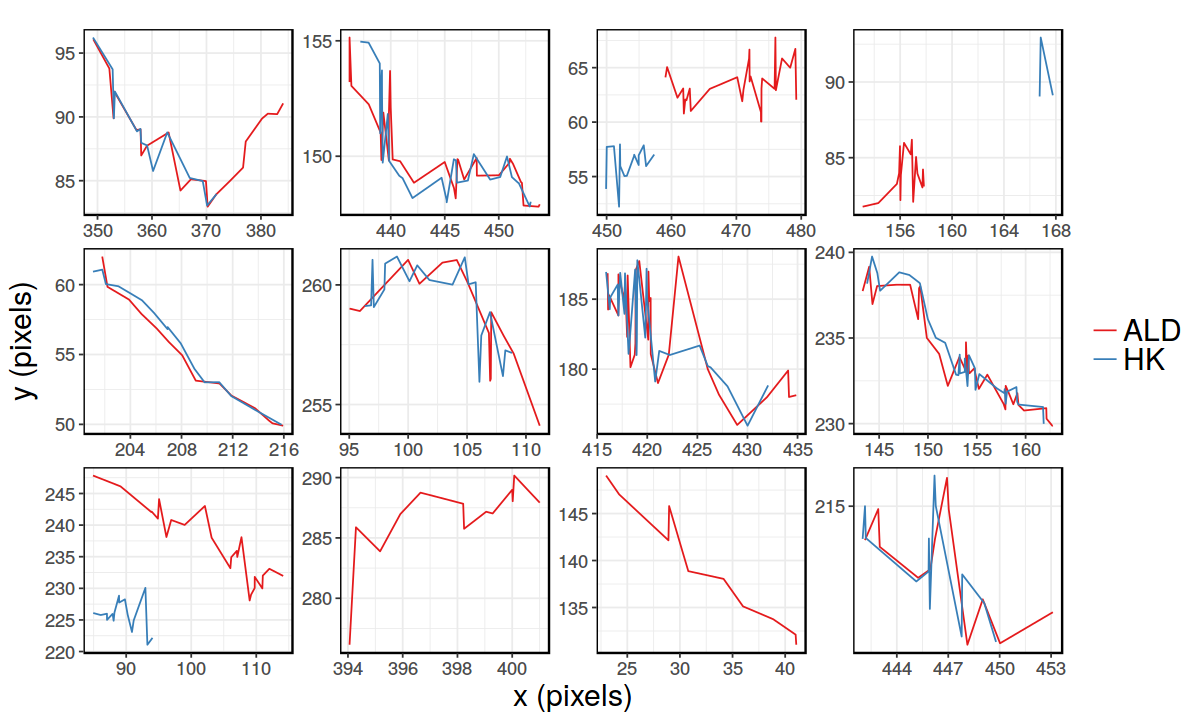

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)
p <- ggplot(data = filter(trajectories, filename == 'with glucose 2'), 
                aes(x = x, y = y, color = factor(channel))) + geom_line() + 
                facet_wrap(~pair_id, scale = "free") +
                theme_bw() +
        xlab("x (pixels)") +
        ylab("y (pixels)") +
                 theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=11),
        axis.text.x = element_text(size=11),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        legend.title=element_blank(),
        legend.text=element_text(size=18),
         strip.text = element_text(size = 0, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA),
                      panel.spacing.y = unit(-.35555, "lines")) +
scale_y_continuous(breaks = seq(0, 800, by=5)) +
scale_color_brewer(palette = 'Set1',labels = c("ALD","HK"))
            
p

In [13]:
ggsave("../img/aggregate_trajectory.png", width =10, height =6, dpi = 300)

## Helper Function definitions

In [172]:
# this returns the p values given a data frame with several trajectories
trajectory_p_vals <- function(df, func, default) {
    p_vals <- 0
    i <- 1
     for (pair in unique(df$pair_id)) {
        # print(pair)
        this_df <- df %>% filter(pair_id == pair)
         
         p_vals[i] <- single_trajectory_p_val_x(this_df, func, default)
         i <- i+1
         p_vals[i] <- single_trajectory_p_val_y(this_df, func, default)
         i <- i+1
     }

    p_vals
}

my_ccm_func <- function(df) {
    res <- ccm(df, output = FALSE, lags=1)
    res$pvalue[1]
}

my_cor_func <- function(df) {
    cor(df)[2,1]
}

single_trajectory_p_val_x<- function(df, func, default) {
    ispresent <- df %>% select(x, channel, frame)

    if(length(unique(ispresent$channel))> 1) {
        to_run_df <- ispresent %>% 
         spread(channel, x) %>%
         select(2:3) %>%
         na.omit()
        
        if(nrow(to_run_df) >5) {
             res <- to_run_df %>% func()
            p_val <- res
        } else {
            p_val <- default
        }
    } else {
        p_val <- default
    }
   p_val 
}
    
single_trajectory_p_val_y<- function(df, func, default) {
    ispresent <- df %>% select(y, channel, frame)

    if(length(unique(ispresent$channel))> 1) {
        to_run_df <- ispresent %>% 
         spread(channel, y) %>%
         select(2:3) %>%
         na.omit() 
        
        if(nrow(to_run_df) >5) {
             res <- to_run_df %>% func()
            p_val <- res
        } else {
            p_val <- default
        }
    } else {
        p_val <- default
    }
   p_val 
}
# this take a vector of p values and aggregates it using Fisher's method
aggregate_pvals <- function(p_vals) {
    p_vals <- p_vals[p_vals>0]
    n_df <- 2* length(p_vals)
    pchisq(-2*sum(log(p_vals)), n_df, lower.tail=FALSE) 
}

### Running the analysis

In [181]:
fn <- "no glucose"

In [182]:
df = filter(trajectories, filename == fn)

In [183]:
trajectory_p_vals(df, my_cor_func, 0)

[1] 0.9943028 0.9371969

In [184]:
df2 = filter(df, pair_id == 0)

In [185]:
df2

frame,x,y,mass,size,ecc,signal,raw_mass,ep,frame.1,particle,filename,channel,pair_id,channe,positive
56,412.7601,131.0649,88.80454,1.225494,0.26595402,13.858726,307,0.08761689,56,4,no glucose,0,0,0,0
57,413.8546,133.7007,70.10964,1.278418,0.14504864,9.419367,281,0.10868066,57,4,no glucose,0,0,0,0
59,414.9622,135.3045,75.03628,1.228343,0.13410075,12.064472,294,0.09378896,59,4,no glucose,0,0,0,0
60,417.7931,136.2181,93.26709,1.271471,0.13081462,13.368807,307,0.08598968,60,4,no glucose,0,0,0,0
61,420.1502,138.9464,74.91314,1.335183,0.07508599,9.223974,284,0.10272355,61,4,no glucose,0,0,0,0
62,420.9738,138.1369,80.84287,1.292262,0.17978377,11.246553,311,0.08428245,62,4,no glucose,0,0,0,0
63,420.9495,143.1477,69.10150,1.227352,0.11807785,11.266548,281,0.10543497,63,4,no glucose,0,0,0,0
64,420.1605,140.1977,65.85859,1.336142,0.09930000,7.894329,280,0.10895524,64,4,no glucose,0,0,0,0
65,419.0118,139.0522,98.57724,1.231076,0.24955925,15.632585,323,0.07790996,65,4,no glucose,0,0,0,0
67,414.9315,139.9292,68.32321,1.256805,0.25936548,10.117548,272,0.11629744,67,4,no glucose,0,0,0,0


In [186]:
single_trajectory_p_val_x(df2)

ERROR: Error in function_list[[k]](value): argument "func" is missing, with no default


In [187]:
ispresent <- df2 %>% select(x, channel, frame)

In [188]:
to_run_df <- ispresent %>% spread(channel, x) %>% select(2:3) %>% na.omit()

In [189]:
to_run_df

,0,1
2,413.8546,413.1521
4,414.9622,414.8531
5,417.7931,417.3054
6,420.1502,420.0316
7,420.9738,420.2597
8,420.9495,420.9656
9,420.1605,420.1064
10,419.0118,418.2517
12,414.9315,415.0464
13,412.8585,412.2158


In [141]:
my_cor_func(to_run_df)

[1] 0.9990698

In [124]:
r.con(cor(to_run_df)[2,1],4 ,p=.99)

[1] 0.8512168 0.9999946

In [160]:
positive_ps <- vector()
negative_ps <- vector()

for (fn in unique(trajectories$filename)) {
    df = filter(trajectories, filename == fn)
    if(fn %in% positives) {
        print(fn)
        positive_ps = c(positive_ps, trajectory_p_vals(df, my_ccm_func, 1))
    } else if (fn %in% negatives) {
        print(fn)
        negative_ps = c(negative_ps, trajectory_p_vals(df, my_ccm_func, 1))
    }
}


[1] "with glucose with 20X objective"
[1] "with glucose 5"
[1] "with glucose 2"
[1] "with glucose 3"
[1] "no glucose"
[1] "l-glu"


In [161]:
aggregate_pvals(positive_ps)

[1] 0

In [162]:
aggregate_pvals(negative_ps)

[1] 0.7115371

In [173]:
positive_cors <- vector()
negative_cors <- vector()

for (fn in unique(trajectories$filename)) {
    df = filter(trajectories, filename == fn)
    if(fn %in% positives) {
        print(fn)
        positive_cors = c(positive_cors,
                          trajectory_p_vals(df, my_cor_func, 0))
    } else if (fn %in% negatives) {
        print(fn)
        negative_cors = c(negative_cors,
                          trajectory_p_vals(df, my_cor_func, 0))
    }
}

[1] "with glucose with 20X objective"
[1] "with glucose 5"
[1] "with glucose 2"
[1] "with glucose 3"
[1] "no glucose"
[1] "l-glu"


In [177]:
length(positive_cors)

[1] 1280

In [178]:
mean(positive_cors[positive_cors >0])

[1] 0.4584823

In [179]:
negative_cors

[1] 0.9943028 0.9371969 0.0000000 0.0000000

In [180]:
df = filter(trajectories, filename == fn)

In [57]:
ha <- trajectory_p_vals(df)

In [58]:
ha

[1] 4.410317e-01 2.028850e-01 0.000000e+00 0.000000e+00 4.020781e-01
   [6] 2.758749e-01 5.259818e-04 1.114797e-03 1.128098e-12 1.181488e-11
  [11] 2.231257e-03 6.805459e-03 0.000000e+00 0.000000e+00 7.492574e-03
  [16] 1.752070e-01 6.174443e-02 3.879983e-02 2.774226e-02 1.956477e-01
  [21] 1.000000e+00 1.000000e+00 6.949630e-01 6.949630e-01 4.486962e-02
  [26] 3.177640e-03 4.341088e-01 5.719065e-01 4.250262e-01 8.030594e-01
  [31] 0.000000e+00 0.000000e+00 2.727171e-02 9.042763e-02 1.000000e+00
  [36] 1.000000e+00 8.225293e-02 2.833399e-01 1.194998e-02 7.177123e-03
  [41] 0.000000e+00 0.000000e+00 8.363036e-02 7.347457e-03 3.824498e-02
  [46] 2.786205e-04 3.516959e-02 5.007568e-02 7.434349e-03 3.020759e-01
  [51] 9.808325e-01 9.444869e-01 3.771737e-01 9.121802e-01 0.000000e+00
  [56] 0.000000e+00 8.479278e-01 4.115931e-01 9.281111e-02 1.471756e-02
  [61] 9.047423e-08 5.191902e-11 6.780182e-01 2.878315e-01 4.304747e-01
  [66] 6.833226e-01 1.898138e-01 1.065815e-01 5.211668e-01 8.301306e-02
  [71] 8.232591e-02 2.584130e-01 1.607160e-03 1.322218e-03 9.582035e-03
  [76] 4.035032e-03 2.539834e-06 1.306570e-07 2.093641e-09 2.310855e-09
  [81] 9.333264e-01 8.003215e-01 1.000000e+00 1.000000e+00 3.142351e-06
  [86] 5.115688e-03 1.000000e+00 1.000000e+00 2.228443e-01 7.454877e-02
  [91] 9.201151e-01 4.959876e-01 3.514204e-01 2.759851e-01 6.949630e-01
  [96] 6.949630e-01 3.748996e-01 1.581456e-01 3.336627e-01 5.605515e-01
 [101] 0.000000e+00 0.000000e+00 3.124762e-01 3.301278e-01 9.609364e-01
 [106] 2.928159e-02 1.000000e+00 1.000000e+00 2.517570e-02 4.757630e-02
 [111] 1.207931e-02 1.660921e-03 1.662460e-01 8.568450e-02 0.000000e+00
 [116] 0.000000e+00 4.223512e-01 8.559980e-01 3.436123e-01 4.297278e-01
 [121] 2.821167e-04 1.472873e-02 3.956645e-02 9.522536e-01 2.596057e-02
 [126] 2.754351e-02 2.067949e-01 5.960466e-01 2.386199e-01 2.324703e-01
 [131] 7.537082e-01 9.524804e-01 4.304371e-01 2.877789e-01 0.000000e+00
 [136] 0.000000e+00 8.129210e-02 5.077530e-01 5.343482e-01 4.093819e-01
 [141] 2.306856e-01 8.326645e-02 1.000000e+00 1.000000e+00 1.000000e+00
 [146] 1.000000e+00 2.322599e-01 5.151643e-01 8.141713e-01 5.411557e-01
 [151] 4.255385e-03 1.960374e-01 8.992740e-03 2.483748e-02 0.000000e+00
 [156] 0.000000e+00 9.106996e-01 3.409762e-01 1.579315e-09 1.889457e-08
 [161] 8.159830e-03 4.267282e-03 6.409084e-03 4.588929e-03 1.911126e-02
 [166] 7.304235e-02 1.000000e+00 1.000000e+00 2.839785e-01 3.721800e-01
 [171] 0.000000e+00 0.000000e+00 4.704403e-02 7.168872e-02 2.956715e-01
 [176] 2.149461e-01 8.164910e-01 8.328277e-01 1.000000e+00 1.000000e+00
 [181] 2.443432e-01 1.779722e-01 1.000000e+00 1.000000e+00 1.000000e+00
 [186] 1.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 1.000000e+00
 [191] 3.047816e-01 9.558249e-03 1.272757e-01 1.852199e-01 3.951084e-01
 [196] 9.928999e-01 4.359502e-04 4.957197e-02 1.585020e-01 2.442857e-01
 [201] 7.914179e-02 1.532028e-02 1.048270e-01 5.788503e-01 3.141133e-01
 [206] 5.831767e-01 7.357800e-02 5.327153e-02 4.926105e-01 6.746014e-01
 [211] 1.276187e-06 2.305509e-06 1.708930e-01 1.837389e-01 9.733770e-02
 [216] 3.119147e-01 8.834415e-01 5.214481e-01 2.249618e-01 1.213007e-01
 [221] 5.884708e-02 3.062264e-02 3.610735e-01 6.274177e-02 2.161705e-01
 [226] 7.432665e-01 7.896106e-02 2.317503e-02 2.561879e-01 5.000744e-01
 [231] 1.713275e-01 1.966392e-01 3.377004e-03 9.659244e-04 4.267471e-03
 [236] 3.575306e-02 4.932120e-01 5.558721e-01 7.183971e-01 4.808279e-01
 [241] 1.000000e+00 1.000000e+00 5.005479e-01 1.833028e-01 4.667088e-02
 [246] 1.770433e-02 2.118376e-01 3.092957e-01 8.049724e-09 1.867213e-09
 [251] 9.181309e-01 6.553119e-01 7.323875e-01 6.847175e-01 1.000000e+00
 [256] 1.000000e+00 6.910810e-01 1.682903e-01 1.000000e+00 1.000000e+00
 [261] 3.689828e-01 4.297454e-01 3.423767e-01 6.420122e-01 1.000000e+00
 [266] 1.000000e+00 7.566534e-02 1.695403e-01 1.000000e+00 1.000000e+00
 [271] 1.476164e-02 3.783463e-02 7.640440e-02 3.413215e-02 2.712864e-01
 [276] 2.675529e-01 6.928999e-02 1.093256e-

In [59]:
aggregate_pvals(ha)

[1] 0

In [207]:
c(1,2,3)

[1] 1 2 3

In [208]:
1:3

[1] 1 2 3

In [210]:
c(1,2,3) == (1:3)

[1] TRUE TRUE TRUE

In [211]:
c(1:3)

[1] 1 2 3